# Atelier IA : Classification de chiffres manuscrits 

## Introduction 

L'IA peut permettre de résoudre de nombreux problèmes complexes que l'informatique traditionnelle peine à traiter.

Ici, notre problème est l'analyse de chiffres manuscrits. Comment obtenir un programme capable de "deviner" à quel chiffre correspond une image de chiffre dessiné par un utilisateur comme ceci ?

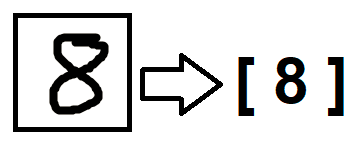

De nos jours, avec la forte puissance de calcul des ordinateurs et toutes les ressources gratuites et libres qui existent, le *machine learning* et plus particulièrement le *deep learning* avec ses réseaux de neurones profonds est particulièrement adapté à résoudre ce type de problème sur des images.

Pour un ordinateur, les images en noir et blanc ne sont que des tableaux de valeurs (matrices) où chaque case représente un pixel allant de 0 (noir pur) à 255 (blanc pur).

Par le jeu d'algorithmes mathématiques que nous allons implémenter en python, l'ordinateur va pouvoir "apprendre" à déceler des motifs sur ces pixels et comprendre les images c'est-à-dire en extraire du sens. C'est de cette façon qu'une machine peut "voir".

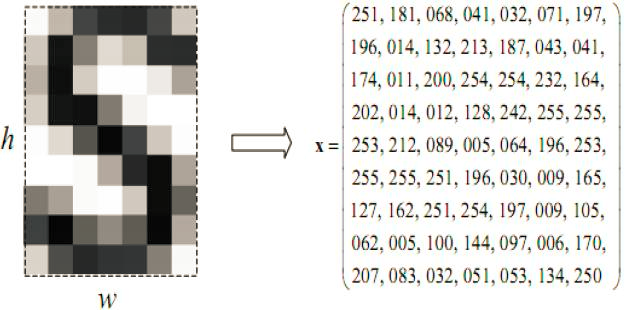

L'idée est d'entraîner un modèle d'IA avec ce type d'images de chiffres manuscrits étiquetés. On appelle cela l'apprentissage supervisé car l'algorithme dispose à la fois des questions (les dessins de chiffres) et des réponses  (les entiers correspondants) lors de son apprentissage.

Pour ce projet, nous allons procéder en 3 grandes étapes :

    1) Récupérer et préparer la donnée

    2) Entraîner le modèle avec cette donnée

    3) Réaliser une interface graphique branchée sur notre modèle

import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV,cross_val_predict

from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix,f1_score,precision_recall_curve,roc_curve,roc_auc_score
import numpy as np
from sklearn.base import BaseEstimator
import cv2

# 1) Preparation des données

## Téléchargement des données

La donnée est le carburant de l'IA. Pas de données, pas de modèle, pas de chocolat.

A l'aide du module sklearn, nous allons récupérer le mnist_784, un jeu de données ou *dataset* de chiffres manuscrits très populaire.

La méthode fetch_openml() est disponible dans le sous-module datasets de sklearn. Nous allons importer cette méthode et l'utiliser pour récupérer le "mnist_784" (utiliser le paramètre de version = 1).

In [1]:
# Importer la méthode fetch_openml depuis le sous-module sklearn.datasets :



# Créer un dictionnaire à l'aide de la méthode fetch_openml() avec les bons paramètres :



# Afficher les clés du dictionnaire ainsi créé :




In [2]:
# Correction :
from sklearn.datasets import fetch_openml
dataDict=fetch_openml('mnist_784', version=1)

print("Affichage des cles du dictionnaire : ")
for cle in dataDict.keys():
    print(cle)

Affichage des cles du dictionnaire : 
data
target
frame
categories
feature_names
target_names
DESCR
details
url


## Exploration des données

La clé "data" du dictionnaire obtenu via `fetch_openml()` a pour valeur les images sous forme de matrices de pixels dans le *range* 0-255.

On peut regarder la forme ou *shape* des matrices de pixels qui composent chaque image avec la méthode `shape` de numpy :

In [3]:
# Afficher la shape d'une image avec la méthode shape() :




In [4]:
# Correction :
dataDict["data"][0].shape

(784,)

On voit que l'image fait 784 pixels.

L'image est totalement déroulée en longueur mais c'est en réalité un carré de 28 par 28 pixels.

Si on veut l'afficher, il faut la transformer aux dimensions (28,28)

On peut ainsi afficher ces images avec la méthode `imshow()` du module pyplot.

In [5]:
# Afficher une image avec la méthode imshow() de numpy appliquée à une instance redimensionnée en 28x28 avec reshape() :




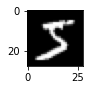

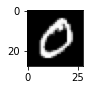

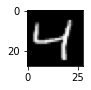

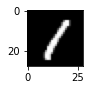

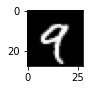

In [6]:
# Correction : 
import matplotlib.pyplot as plt

# Affichons quelques chiffres
for i in range (0,5):
    plt.figure(figsize=(1,2))
    plt.imshow(dataDict["data"][i].reshape(28,28), cmap="gray")

Nous allons maintenant créer une variable X et une variable y.

Traditionnellement, "X" correspond aux variables d'apprentissage (aussi appelées features), ici nos images de chiffres passées en matrices. La variable "y" correspond quant à elle à la cible, aussi appelée *target* ou *label*. Dans notre cas, c'est un entier allant de 0 à 9 associé à l'image de chiffre.

Tout l'objectif du modèle est de trouver (ou "prédire") le bon y à partir de tout x correctement formaté qui lui est passé.

In [ ]:
# Créez la variable de features X avec la clé data :
X=


# Créez la variable de target y avec la clé target :
y=


# Pour le moment les labels sont des strings.
# Passez donc la target sous forme d'int avec un cast (on peut utiliser la méthode astype de numpy) :




In [8]:
# Correction
X=dataDict['data']
y=dataDict['target']
y=y.astype('int')

## Repartition des données en train/test set :

train_test_split() est une méthode du module sklearn (scikit-learn) qui permet de diviser notre dataset entre une partie *train* pour l'apprentissage et une partie *test* pour la validation.

Les paramètres que l'on va utiliser pour le split sont :

**Nos features X**

**Notre target y**

**test_size:** la taille visée pour le test, mettre ici `1/7`, pour 1/7 ème de la donnée*

**Shuffle :** on met True en Shuffle pour mélanger aléatoirement la donnée dans l'output du split pour avoir un meilleur apprentissage.

In [ ]:
# Importer la méthode train_test_split() depuis le sous-module model_selection de sklearn.


# Paramétrez le split comme il faut :
x_train, x_test, y_train, y_test =







In [10]:
# Correction :
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=1/7,shuffle=True)

Vérifions avec la cellule suivante que l'on a bien 60 000 images en train et 10 000 en test :

In [ ]:
print("Il y a {} valeurs dans notre base d'apprentissage".format(x_train.shape[0]))
print("Il y a {} valeurs dans notre base d'apprentissage".format(x_test.shape[0]))

## Normalisation et reshape des données

Dernière étape avant de passer au modèle, nous allons normaliser nos images et les redimensionner pour qu'elles soient aux bonnes dimensions pour notre modèle.

La normalisation va mettre chaque valeur de pixel initialement comprise entre 0 et 255 dans un range allant de 0 à 1. C'est une bonne pratique pour homogénéiser les données et cela peut aider les algorithmes.

In [ ]:
# Normalisez les données en divisant les valeurs des pixels par 255 :
images_train =

images_test = 


In [12]:
# Correction

images_train = x_train.astype('float')/255
images_test = x_test.astype('float')/255

Le reshape est fait avec avec la méthode `reshape()` de Numpy aux dimensions de -1, 28, 28, 1 :

In [ ]:
# Reshape du train et du test pour fonctionner avec le modèle :
images_train = 

images_test = 



In [13]:
# Correction
images_train = images_train.reshape(-1,28,28,1)
images_test = images_test.reshape(-1,28,28,1)

# 2) Création du modèle 

Nous allons utiliser tensorflow avec keras pour créer et entraîner notre modèle. Ce sont des outils open source puissants et qui facilitent l'expérimentation. Keras est inclus dans tensorflow.

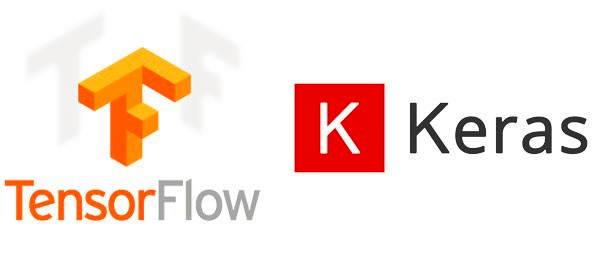

Import de tensorflow :

In [ ]:
# Importez le module tensorflow avec l'alias tf :


In [14]:
# Correction :
import tensorflow as tf

Nous allons créer un modèle de type séquentiel avec keras mais préparons d'abord nos callbacks.

**Création de callbacks.**

Les callbacks sont des méthodes de keras qui vont nous faire gagner du temps. On les met dans une liste et l'on passera cette liste à la méthode d'apprentissage `fit()` lorsqu'on entraînera le modèle.

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Le Early Stopping est un callback qui va stopper l'apprentissage afin d'éviter le suraprentissage.
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

# Le Reduce LR on Plateau va réduire le learning rate lorsque la val_accuracy atteint un plateau afin
# que le modèle continue à apprendre des features interessantes :
ReduceLROnPlateau = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

# On charge nos callbacks dans une liste :
callbacks = [early_stopping, ReduceLROnPlateau]

**Instanciation du modèle**


Instanciez un modèle dans une variable `model` avec la méthode Sequential() de keras. Aucun paramètre n'est nécessaire :

In [ ]:
# Instanciation du modèle : 
model =

In [16]:
# Correction :
model = tf.keras.Sequential()

**Création des couches de neurones**

Quand on crée un modèle sequentiel sur keras, c'est comme faire un sandwich. Cela fonctionne par couches successives qu'on ajoute au modèle avec la méthode `add()` de keras.

On ouvre le sandwich avec la première tranche de pain, la couche d'entrée ou *input* qui reçoit les images. Puis de couche en couche on finit sur la tranche qui referme le sandwich : la couche de sortie ou *output*. Les couches entre l'input et l'ouput sont appelées les couches cachées ou *hidden layers*.

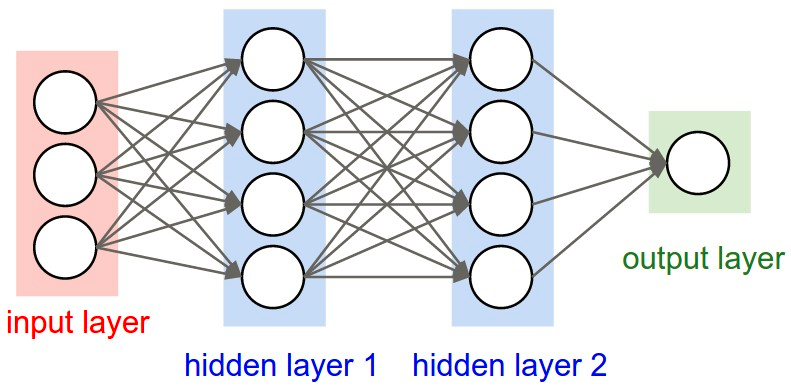

**La convolution**

Ajoutons maintenant les couches de notre modèle. On va commencer par une couche de convolution 2D avec la méthode Conv2D() de keras.

La couche de convolution est le bloc de base pour construire un CNN (Convolutional Neural Network). Il s'agit de neurones qui vont recevoir et traiter l'image par petits bouts. C'est inspiré par le fonctionnement des véritables neurones du cerveau qui traitent chacun une partie de l'information de notre champ visuel.

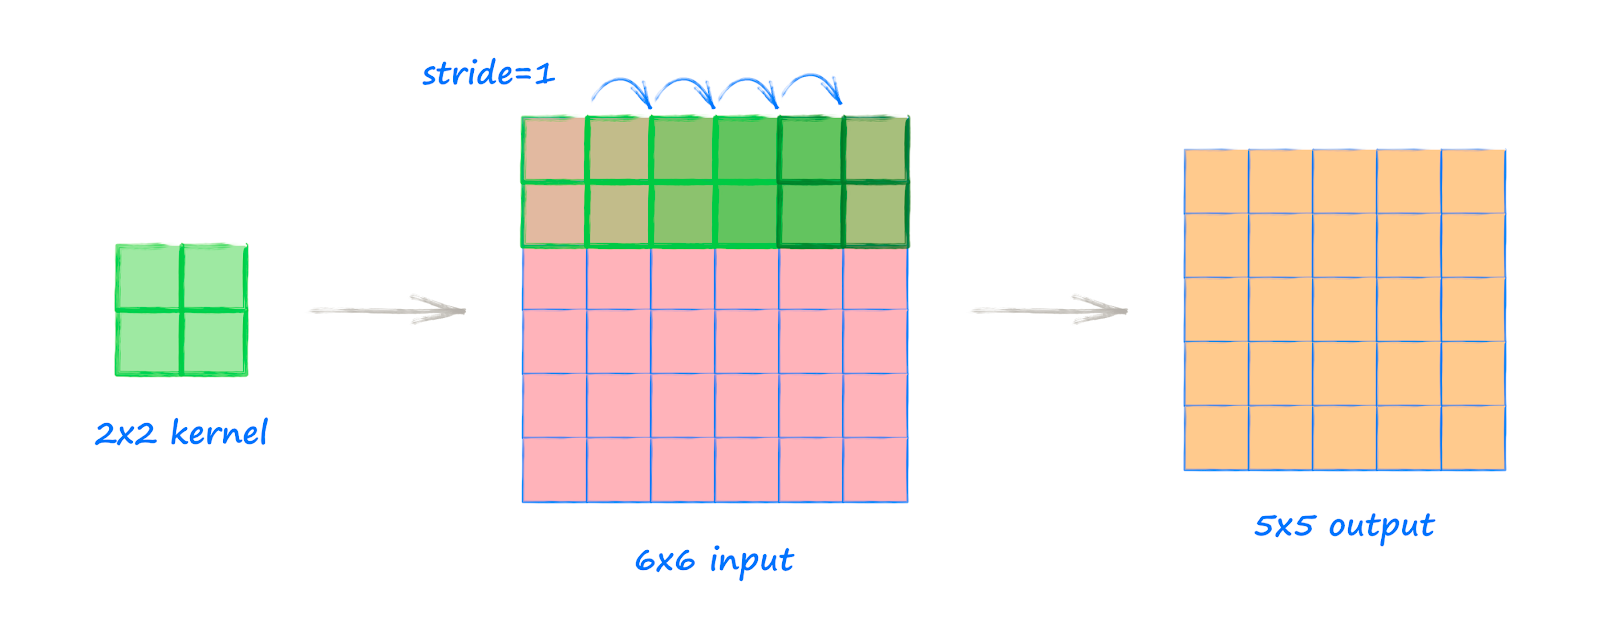
Sur l'image ci-dessus, notez comme l'output est plus petit que l'inpu : la convolution rétrécit progressivement la taille de l'image.

On ajoute chaque couche à notre modèle en faisant `model.add(la couche)`.

Les couches peuvent être un peu compliquées et intimidantes à paramétrer. En cas d'erreur, on peut toujours ré-instancier le modèle afin de tout effacer !

In [ ]:
# Création du modèle : 

# 1ère couche de convolution :
model.add(tf.keras.layers.Conv2D(filters = 64,
                                 kernel_size = 10,
                                 activation='elu',
                                 input_shape=(28, 28, 1),
                                 padding="same",
                                 kernel_initializer='he_normal'))

model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GaussianNoise(0.5))


# 2ème couche de convolution :
model.add(tf.keras.layers.Conv2D(32, 
                 8, 
                 activation='elu',
                 padding="same",
                 kernel_initializer='he_normal'))


model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GaussianNoise(0.5))

# 2ème couche de convolution :
model.add(tf.keras.layers.Conv2D(32, 
                 7, 
                 activation='elu',
                 padding="same",
                 kernel_initializer='he_normal'))


model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GaussianNoise(0.5))

# 3ème couche de convolution :
model.add(tf.keras.layers.Conv2D(32, 
                 6,
                 padding="same",
                 activation='relu'
                 ))

model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GaussianNoise(0.5))

# Ecrasement de l'input pour qu'il soit d'une seule dimension :
model.add(tf.keras.layers.Flatten())

# Passage aux couches dense
model.add(tf.keras.layers.Dense(128, activation='elu'))

model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.Dense(512, activation='elu'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

opti = tf.keras.optimizers.Nadam(learning_rate=0.001)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=opti,
    metrics=["accuracy"]
)

history = model.fit(images_train,
                    y_train,
                    epochs=100,
                    validation_split=0.2,
                    batch_size=156,
                    shuffle=True,
                    callbacks=callbacks,
                    use_multiprocessing=True)

**Sommaire du modèle**

Afin de visualiser l'architecture de notre modèle sous la forme d'un sommaire (sorte de "ticket de caisse" récapitulatif), nous allons utiliser la méthode summary() sur le modèle.

In [ ]:
# Utilisez la méthode summary() sur le modèle :







In [ ]:
# Correction : model.summary()

Remarquez le "Param #" tout à droite, il s'agit des "poids" des neurones, les paramètres que l'on va affiner à chaque tour d'apprentissage de notre modèle.

Seules les couches de neurones ont des paramètres. Les autres couches affichent 0 paramètres.

Notre modèle a quatre couches de convolution 2D et 3 couches denses, output compris. Il s'agit donc bien d'un CNN (*Convolutional Neural Network*).

Notez aussi que la dernière couche Dense, appelée l'*output*, a 10 neurones de sortie, 1 pour chaque catégorie de chiffre !

**Compilation du modèle :**

Une fois le modèle créé, il faut indiquer qu'on ne souhaite plus retoucher son architecture.

Compilez-le donc avec la méthode compile() en utilisant 3 paramètres : *loss*, *optimizer*  et *metric*.

**Loss :** correspond à la fonction coût, c'est l'erreur de notre modèle. Plus il prédit bien le chiffre par rapport à l'image qu'il reçoit et plus le loss est faible. Tout l'objet de l'apprentissage d'un modèle est de minimiser la fonction coût.

Pour ce paramètre, on va choisir "sparse_categorical_crossentropy" car on a plusieurs labels ("catégories") et qu'on veut que le modèle attribue un score de probabilité le plus élevé possible au bon label. 

**Optimizer :** l'optimiseur est une implémentation d'un algorithme d'apprentissage. Nous allons utiliser "Adam", un algorithme dit de descente de gradient. Il faut comprendre que l'on va descendre la courbe de la fonction coût/loss en approchant le réglage optimal pour chaque paramètre de nos neurones. Le réglage optimal est celui où la dérivée de la fonction coût par rapport aux paramètres est nulle, c'est son point le plus bas :
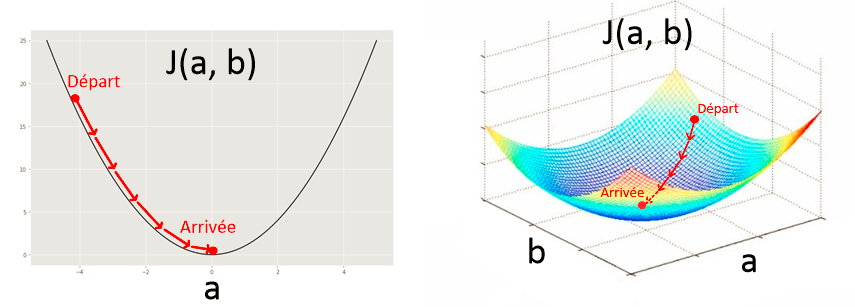

**metrics :** on va suivre un métrique de précision afin d'avoir une visibilité sur les performances de notre modèle à chaque tour d'apprentissage. Ce paramètre est facultatif.

Mettez ["accuracy"] pour ce paramètre.

In [ ]:
# Compiler ici le modèle avec la méthode compile et les bons paramètres :







In [ ]:
# Correction :
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

**Apprentissage du modèle**

Voici le moment tant attendu, l'apprentissage du modèle. Pour ce faire, on va utiliser la méthode fit sur le modèle et l'on charge cela dans une variable history.

On peut bien sûr *fit* le modèle immédiatement sans passer cet apprentissage dans une variable mais avoir un history permet de tracer une courbe de progression pour visualiser l'apprentissage sur un graphique.

Pour la méthode fit, on va passer plusieurs paramètres :

**Les features d'apprentissage :** il s'agit ici d'images_train, nos images de chiffres.

**La target y associée :** il s'agit ici de y_train, nos labels de chiffres sous forme d'entiers.

**epochs :** le nombre de tours d'apprentissages est appelé epochs. On va en avoir besoin de 10.

**validation_split** : c'est la validation croisée qui aura lieu lors de chaque epoch, notre modèle va se conserver une partie (flottante) de la donnée pour se valider lui-même. On va mettre 0.2 soit 20% de la data utilisée pour la validation.

In [ ]:
# Réaliser le fit() de notre modèle avec les bons paramètres et le charger dans une variable history :







In [ ]:
# Correction :
history = model.fit(images_train,
                    y_train,
                    epochs=10,
                    validation_split=0.2)

Notre modèle est entraîné, on va pouvoir le sauvegarder sous forme de dossier afin de pouvoir s'en servir ailleurs. En l'occurence, nous allons l'utiliser dans notre programme d'interface graphique !

Pour ce faire, on peut passer par google drive. On va importer le module drive, monter notre drive et sauvegarder le modèle dedans. Ensuite on pourra le télécharger pour le réutiliser ailleurs.

In [ ]:
# Importer le sous-module drive de google.colab avec un "from... import" :



# Montez votre drive avec drive.mount("/content/gdrive/") :




# Enregistrer le modèle avec la méthode save() et le chemin souhaité en paramètre :




In [ ]:
# Correction :
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
model.save("/content/gdrive/My Drive/modele_chiffres_manuscrits")